# Projet d'attaques adversariales


## Nicolas Fabiano, Minh Dinh & Alexis Amzallag

### Contexte
Les modèles de Machine Learning sont déployés dans diverses tâches, y compris la classification des images, détection de logiciels malveillants, etc. Mais des travaux récents ont démontré que même les réseaux neuronaux profonds de pointe, qui excellent dans ces tâches, sont vulnérables à une classe d'intrants malveillants connus sous le nom d'exemples contradictoires. Ces exemples sont des intrants non aléatoires qui sont presque impossibles à distinguer des données naturelles et qui sont pourtant mal classées.



### Adversarial Examples

En modifiant certains bits du fichier qui sont bénins, nos systèmes pourraient prédire qu'il s'agit d'un fichier bénin (bien qu'il n'ait pas modifié la partie malveillante du fichier, il devrait donc être classé comme un logiciel malveillant) et ne le bloquerait pas, posant ainsi un risque de sécurité pour l'ordinateur.

Les algorithmes d'apprentissage machine sont généralement conçus en supposant que les modèles sont formés sur des échantillons tirés d'une distribution représentative des échantillons d'essai pour lesquels nous ferions des prédictions par la suite. Cependant, cela n'est pas vrai dans le cas d'exemples contradictoires.

Ce projet à pour but d'aborder le sujet des attaques adversiales. C'est-à-dire de réussir, par une modification la plus imperceptible possible, à tromper un réseau de neurone entraîné pour un problème de classification.

Trois approches seront ici abordées :

*   la Fast Gradient Sign Method
*   la Projected Gradient Descent
*   les attaques Black Box

# **I. Fast Gradient Sign Method**


Le principe de la FGSM repose sur l'idée de trouver une perturbation à infliger à l'image source telle que chaque pixel perturbé ne soit, individuellement, pas "trop" différent du pixel de l'image source. C'est-à-dire de trouver une perturbation dont la valeur de norme l-infini ne soit pas "trop" élevée.


Il s'agira donc de trouver, pour chaque pixel, de trouver "dans quel sens" le modifier par liais du gradient (ou plutôt de son signe), et de lui affecter dans se sens le changement maximal que l'on aura autorisé. 

## Imports

In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import RMSprop
from keras.losses import sparse_categorical_crossentropy
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random


Using TensorFlow backend.


### Functions

In [0]:
''' Cette foncion retourne les signes du gradient pour un réseau et une image donnés'''
def get_sign(image, label, model):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    sign_gradient = tf.sign(gradient)
    
    return sign_gradient

In [0]:
''' Cette fonction donne, pour une image et un modèle donnés, la perturbation à efféctuée pour un epsilon valant 1'''
def get_pertur(image, image_label, model) :
  pertur = K.eval(get_sign(image.reshape((1, 32, 32, 3)), image_label, model))
  return pertur


In [0]:
''' Cette fonction permet de réduire une pertubation aux seules contours d'une image'''
def get_pertur2(perturbation, min, max) :
  pertur = perturbation
  for ab in range(32) :
    for j in range(32) :
      if (min<ab<max and min<j<max):
        pertur[0][ab][j] = [0,0,0]
  return pertur
    

In [0]:
''' Cette fonction permet de créer une perturbation pour laquel le sens de modification de chaque pixel est aléatoire'''
def get_pertur3() :
  pertur = np.zeros((1, 32, 32, 3))
  for ab in range(32) :
    for j in range(32) :
      pertur[0][ab][j] = [1 - 2 * random.randint(0,1),1 - 2 * random.randint(0,1), 1-2 * random.randint(0,1)]
  return pertur

In [0]:
'''Cette fonction retourne, pour une liste d'image données, la liste des perturbations obtenues par FGSM'''
def get_perturbations1(dataX, dataY, model) :
  resultat = []
  for i in range(len(dataX)) :
    if (i%50 == 0):
      print(i)
    resultat.append(get_pertur(dataX[i], dataY[i], model))
  return resultat


In [0]:
def get_perturbations2(pertur, min, max) :
  resultat = []
  for i in range(len(pertur)) :
    resultat.append(get_pertur2(pertur[i], min, max))
  return resultat

In [0]:
def get_perturbations3(dataX) :
  resultat = []
  for i in range(len(dataX)) :
    resultat.append(get_pertur3())
  return resultat

In [0]:
''' Cette fonction renvoie, à partir d'une liste d'image et de perturbations ainsi que du seuil autorisé pour la perturbation, la liste des images modifiées'''
def get_attacks(originalX, perturbations, epsilon) :
  res = []
  
  for i in range(len(originalX)) :
    res.append(originalX[i].reshape(1,32,32,3) + epsilon * perturbations[i])
  return res

In [0]:
''' Retourne différentes informations sur l'accuracy et la confiance du modèle sur un groupe d'images attaquées '''

def get_evaluation(originalX, originalY, perturbatedX) :
  nbCorrectPer = 0
  sumConfTTPer = 0
  sumConfTFPer = 0
  sumConfFFPer = 0
  for i in range(len(originalX)) :
    predictionOri = model.predict(originalX[i].reshape(1,32,32,3))
    predictionPer = model.predict(perturbatedX[i].reshape(1,32,32,3))
    if (predictionPer.argmax() == int(originalY[i])) :
      nbCorrectPer += 1
      sumConfTTPer += predictionPer.max()
    if (predictionPer.argmax() != int(originalY[i])) :
      sumConfFFPer += predictionPer.max()
      sumConfTFPer += predictionPer[0][int(originalY[i])]
    
  if(nbCorrectPer != 0):
    print(True)
    sumConfTTPer = sumConfTTPer/nbCorrectPer

  if(nbCorrectPer !=len(originalX)):
    sumConfTFPer = sumConfTFPer/(len(originalX)- nbCorrectPer)
    sumConfFFPer = sumConfFFPer/(len(originalX)- nbCorrectPer)
  #nbCorrectOri = nbCorrectOri/len(originalX)
  print (nbCorrectPer)
  nbCorrectPer = nbCorrectPer/len(originalX)

  print(sumConfFFPer, sumConfTFPer, sumConfTTPer)
  #return nbCorrectOri, nbCorrectPer, sumConfTTori, sumConfTFOri, sumConfFFOri, sumConfTTPer, sumConfTFPer, sumConfFFPer
  return nbCorrectPer, sumConfTTPer, sumConfTFPer, sumConfFFPer





## Entrainement du réseau à attaquer

On crée puis entraîne un réseau que l'on va par la suite attaquer

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [13]:
inputs = Input(shape=(32,32,3), name='img')
x = Conv2D(32, 5, activation='relu', padding='same')(inputs)
x = MaxPooling2D(2)(x)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = AveragePooling2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

In [15]:
model = Model(inputs=inputs, outputs=outputs, name='classif')
model.summary()

model.compile(loss='sparse_categorical_crossentropy',optimizer=RMSprop(lr=0.0001, decay=1e-6),metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128,epochs=400,validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Model: "classif"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0   

## Principe

Le principe est le suivant : on choisit un epsilon traduisant d'a quel point on s'autorise a modifier l'image, et on perturbe chaque pixel en conséquence. Plus epsilon sera grand, plus grande sera la perturbation et plus facile il sera de tromper le réseau, mais plus facile il sera aussi distinguer que l'image a été modifiée.

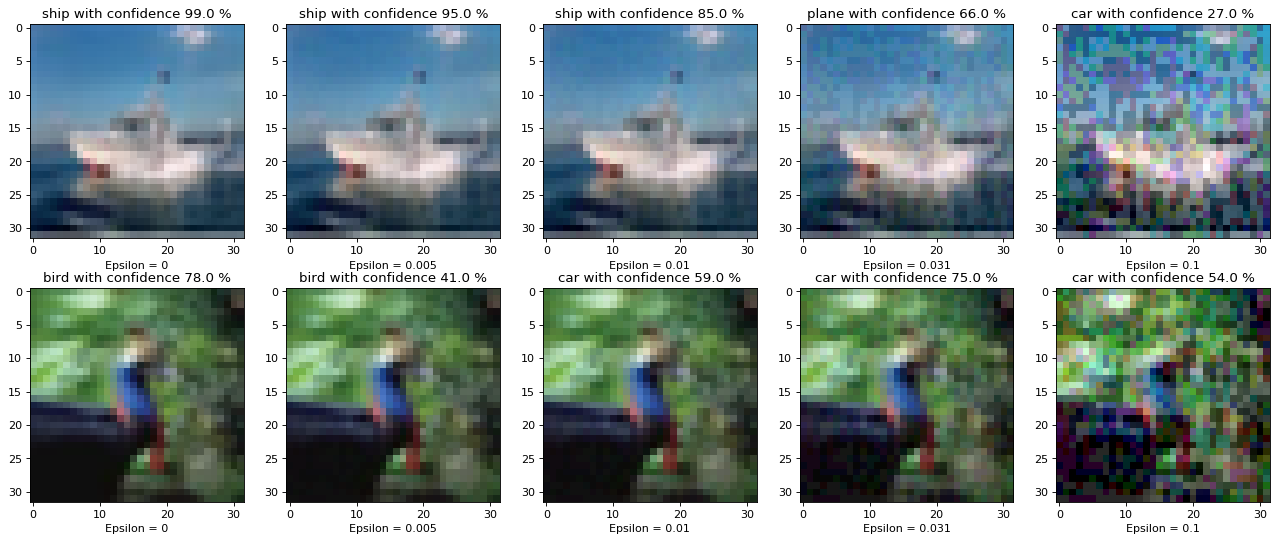

In [77]:
examples = [0, 0.005, 0.01, 0.031, 0.1]
plt.figure(figsize=(20,8), dpi=80)
imgsadv = [get_attacks(x_train[62:64], perturbations1_train[62:64], cdef) for cdef in examples]

for i in range(len(examples)):
  predicti1 = model.predict(imgsadv[i][0].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+1)
  plt.imshow(imgsadv[i][0].reshape(32,32,3))
  plt.xlabel('Epsilon = {}'.format(examples[i]))
  plt.title("{} with confidence {} %".format(classes[predicti1.argmax()], predicti1.max()//0.01))
  
  predicti1 = model.predict(imgsadv[i][1].reshape(1,32,32,3))

  plt.subplot(2,len(examples), i+5+1)
  plt.imshow(imgsadv[i][1].reshape(32,32,3))
  plt.xlabel('Epsilon = {}'.format(examples[i]))
  plt.title("{} with confidence {} %".format(classes[predicti1.argmax()], predicti1.max()//0.01))
plt.show()

## **1) Attaque FGSM classique**

On implémente les attaques FGSM sur cifar10.

In [16]:
#Perturbations for 500 first in train
x_usedtr1 = x_train[:500]
y_usedtr1 = y_train[:500]
perturbations1_train = get_perturbations1(x_train[:500], y_train[:500])
perturbations2_train = get_perturbations2(np.copy(perturbations1_train), 3, 28)
perturbations3_train = get_perturbations3(x_train[:500])

0
50
100
150
200
250
300
350
400
450


In [17]:
  #Perturbations for 500 first in test
x_usedte1 = x_test[:500]
y_usedte1 = y_test[:500]
perturbations1_test = get_perturbations1(x_test[:500], y_test[:500])
perturbations2_test = get_perturbations2(np.copy(perturbations1_test), 3, 28)
perturbations3_test = get_perturbations3(x_test[:500])

0
50
100
150
200
250
300
350
400
450


In [73]:
epsilons = [0, 0.001, 0.003, 0.007, 0.01, 0.02, 0.031, 0.045, 0.07]
resAccTr = []
resConfTTTr = []
resConfTFTr = []
resConfFFTr = []
resAccTe = []
resConfTTTe = []
resConfTFTe = []
resConfFFTe = []
for i in epsilons :
  print(i)
  a, b, c, d = get_evaluation(x_usedtr1, y_usedtr1, get_attacks(x_usedtr1, perturbations1_train, i))
  e, f, g, h = get_evaluation(x_usedte1, y_usedte1, get_attacks(x_usedte1, perturbations1_test, i))
  resAccTr.append(a)
  resConfTTTr.append(b)
  resConfTFTr.append(c)
  resConfFFTr.append(d)
  resAccTe.append(e)
  resConfTTTe.append(f)
  resConfTFTe.append(g)
  resConfFFTe.append(h)


0
True
372
0.5487406322499737 0.18108267415163937 0.7756679922502528
True
336
0.5531501148532076 0.16638999456380388 0.7649651910400107
0.001
True
346
0.5669111405293663 0.17244796283590735 0.7549073111287431
True
306
0.5635073970734459 0.15707003876490228 0.7517343243352728
0.003
True
281
0.5852639328807456 0.16386828053762315 0.7291272055105806
True
248
0.593211757048728 0.14124312176573722 0.7244978322977981
0.007
True
156
0.6256319022802419 0.13101858000400593 0.7353122383356094
True
142
0.6379899856265031 0.10903680140398533 0.7224893716859145
0.01
True
106
0.6702086257223551 0.09744167618306525 0.7229796234729156
True
93
0.6722149449865121 0.08797961270799155 0.7099945256786961
0.02
True
32
0.7535257464290684 0.039087376740604265 0.6967099504545331
True
22
0.7406461844883204 0.03937876175103855 0.6784086986021562
0.031
True
6
0.7843233329443796 0.020033056287063564 0.616248200337092
True
4
0.7766556160584572 0.01693647757046818 0.861845463514328
0.045
True
1
0.7988138933458883 0.


On présente ici les conséquences de l'évolution d'epsilon sur l'accuracy du réseau (pour des exemples d'entrainement comme pour des exemples de test) et sur les niveaux de confiance.

On distinguera 3 moyennes de confiance différentes :

-TT : la moyenne des confiances que le réseau a dans la vrai classe d'une image lorsqu'il prédit la bonne classe

-TF : la moyenne des confiances que le réseau a dans la vrai classe d'une image lorsqu'il ne prédit pas la bonne classe

-FF : la moyenne des confiances que le réseau a dans ses prédictions lorsque ses prédictions sont erronnées.

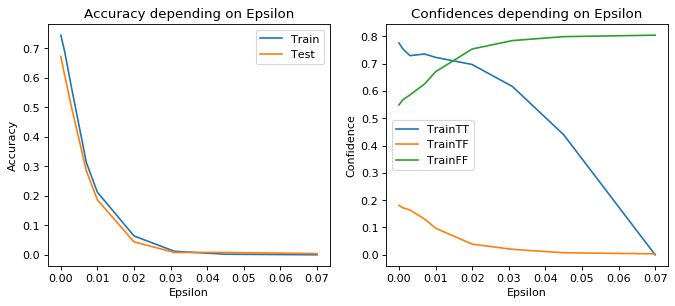

In [74]:
plt.figure(figsize=(10,4), dpi=80)
plt.subplot(121)
plt.plot(epsilons, resAccTr)
plt.plot(epsilons, resAccTe)
plt.title('Accuracy depending on Epsilon')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.show()
plt.subplot(122)
plt.plot(epsilons, resConfTTTr)
plt.plot(epsilons, resConfTFTr)
plt.plot(epsilons, resConfFFTr)
plt.title('Confidences depending on Epsilon')
plt.ylabel('Confidence')
plt.xlabel('Epsilon')
plt.legend(['TrainTT', 'TrainTF', 'TrainFF'], loc='center left')
plt.show()


Les résultats sont probants, pour un epsilon à 0.031, la perturbation est presque imperceptible et le réseau ne fonctionne plus du tout avec un accuracy à 2-3%. On présente ci-dessous quelques exemples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 32, 32, 3)
[[1.57090707e-03 1.42447971e-04 2.01100130e-02 4.11387384e-02
  9.57064852e-02 6.12757623e-01 8.39446264e-04 2.27312967e-01
  1.08436005e-04 3.12911026e-04]] 5
[[8.9199990e-01 8.1820443e-04 1.6230989e-02 6.0697589e-03 1.4000225e-02
  8.7159096e-05 2.2979355e-03 4.0217911e-04 5.6495972e-02 1.1597669e-02]] 0
[[3.2253981e-01 2.3899914e-03 1.5468870e-03 1.6803530e-04 1.0891880e-03
  2.5368433e-06 1.0546263e-04 6.7314891e-06 6.7105722e-01 1.0941484e-03]] 8
[[1.4820585e-03 3.6419975e-04 3.8617514e-02 1.3288851e-02 5.1931566e-01
  3.1155652e-01 1.2068021e-02 1.0257169e-01 7.0842907e-05 6.6460535e-04]] 4


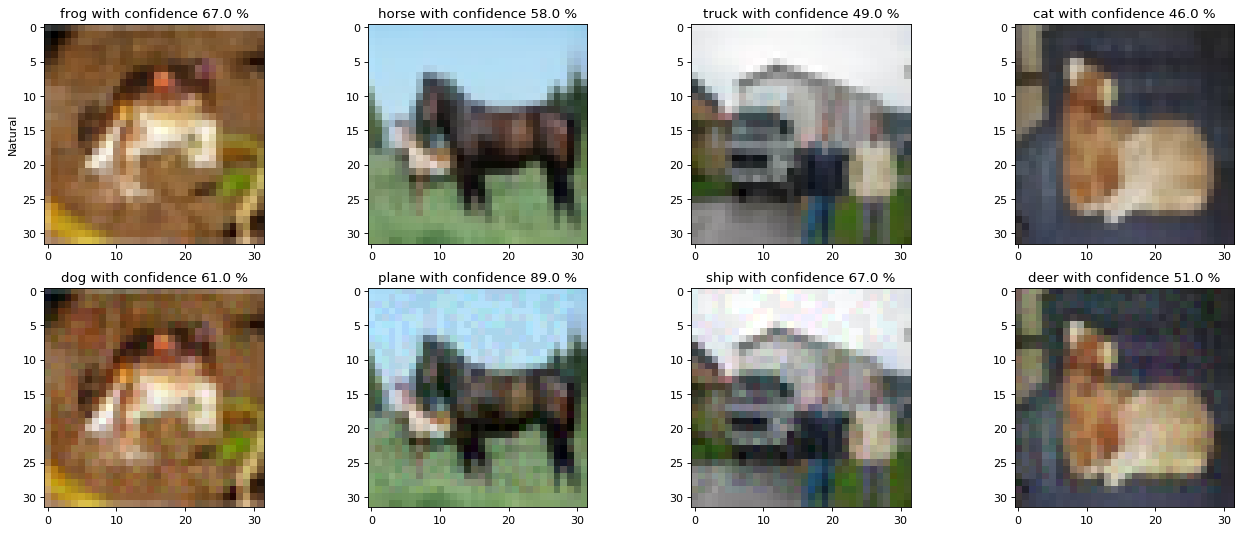

In [0]:
examples = [0,12,16,17]
plt.figure(figsize=(20,8), dpi=80)
imgsadv = get_attacks([x_train[abcd] for abcd in examples], [perturbations1_train[bcde] for bcde in examples], 0.031)
print (imgsadv[0].shape)

for i in range(len(examples)):
  predicti1 = model.predict(x_train[examples[i]].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+1)
  plt.imshow(x_train[examples[i]])
  plt.title("{} with confidence {} %".format(classes[predicti1.argmax()], predicti1.max()//0.01))
  if(i ==0):
    plt.ylabel('Natural')
  
  predicti2 = model.predict(imgsadv[i].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+4+1)
  plt.imshow(imgsadv[i].reshape(32,32,3))
  plt.title("{} with confidence {} %".format(classes[predicti2.argmax()], predicti2.max()//0.01))
  if(i ==4):
    plt.ylabel('Adversarial')
plt.show()


## **2.Attaque FGSM partielle**


Ici on va restreindre les attaques FGSM au contour de l'image de manière à ne pas perturber la partie de l'image dans laquelle se situe le sujet de l'image.

Le but de cette manoeuvre serait d'observer dans quelle mesure l'on pourrait attaquer une image sans toucher a ses parties les plus importantes.

A noter que pour la plupart des classes, les images correspondantes représentent leur sujet dans des décors variés, ainsi on trouve des grenouilles dans de l'herbe de l'eau, de la boue, une main ou encore sur un trottoir.

In [66]:
epsilons = [0, 0.001, 0.003, 0.007, 0.01, 0.02, 0.031, 0.05, 0.075, 0.1]
resAccTr = []
resConfTTTr = []
resConfTFTr = []
resConfFFTr = []
resAccTe = []
resConfTTTe = []
resConfTFTe = []
resConfFFTe = []
for i in epsilons :
  print(i)
  a, b, c, d = get_evaluation(x_usedtr1, y_usedtr1, get_attacks(x_usedtr1, perturbations2_train, i))
  e, f, g, h = get_evaluation(x_usedte1, y_usedte1, get_attacks(x_usedte1, perturbations2_test, i))
  resAccTr.append(a)
  resConfTTTr.append(b)
  resConfTFTr.append(c)
  resConfFFTr.append(d)
  resAccTe.append(e)
  resConfTTTe.append(f)
  resConfTFTe.append(g)
  resConfFFTe.append(h)

0
True
372
0.5487406322499737 0.18108267415163937 0.7756679922502528
True
336
0.5531501148532076 0.16638999456380388 0.7649651910400107
0.001
True
367
0.553221026757606 0.1832037362820623 0.7722148138430852
True
332
0.55505300765591 0.16333294991524044 0.7617590253252581
0.003
True
358
0.5563038546644467 0.1791685781479341 0.7672130002655797
True
318
0.5537624084851244 0.16538755830361668 0.7627541203543825
0.007
True
344
0.568079765408467 0.17020460588313513 0.752940068064734
True
305
0.5660270382196475 0.15347813735268293 0.7482353822129671
0.01
True
336
0.577105048953033 0.1614849307049398 0.7404024395204726
True
291
0.5740917716442683 0.15367886813934117 0.7415911756532708
0.02
True
284
0.5807914460698763 0.167064999092906 0.7319984135388489
True
246
0.5902500553276595 0.14576572760752313 0.7342265592357977
0.031
True
241
0.5909365468503885 0.15353767967493676 0.7245209558376138
True
207
0.610076256223506 0.13235243035697244 0.73110741218507
0.05
True
185
0.6187622724071381 0.13183


On obtient les résultats suivants sur nos tests lorsque l'on perturbe le contour des images sans regarder si cela perturbe le sujet de l'image.

L'accuracy descend moins vite que pour une FGSM classique, du côté des confiances les évolutions sont moins franches, les confiances moyennes pour les vraies classes des images baissent moins que pour une FGSM classique. Tout cela semble assez logique puisqu'une partie de l'image, potentiellement importante, reste inchangée.

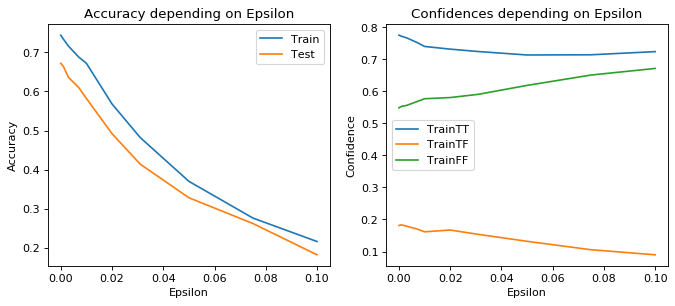

In [67]:
plt.figure(figsize=(10,4), dpi=80)
plt.subplot(121)
plt.plot(epsilons, resAccTr)
plt.plot(epsilons, resAccTe)
plt.title('Accuracy depending on Epsilon')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.show()
plt.subplot(122)
plt.plot(epsilons, resConfTTTr)
plt.plot(epsilons, resConfTFTr)
plt.plot(epsilons, resConfFFTr)
plt.title('Confidences depending on Epsilon')
plt.ylabel('Confidence')
plt.xlabel('Epsilon')
plt.legend(['TrainTT', 'TrainTF', 'TrainFF'], loc='center left')
plt.show()

Certains résultats en revanche, sont plus intéressants, on présente les 4 exemples suivants pour lesquels la perturbation ne touche pas l'animal ou l'objet sujet de l'image mais pour lesquels la prédiction devient erronnée.

Il est donc possible d'effectuer une attaque adversariale en modifiant une partie d'une image supposée peu utile pour la reconnaissance.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


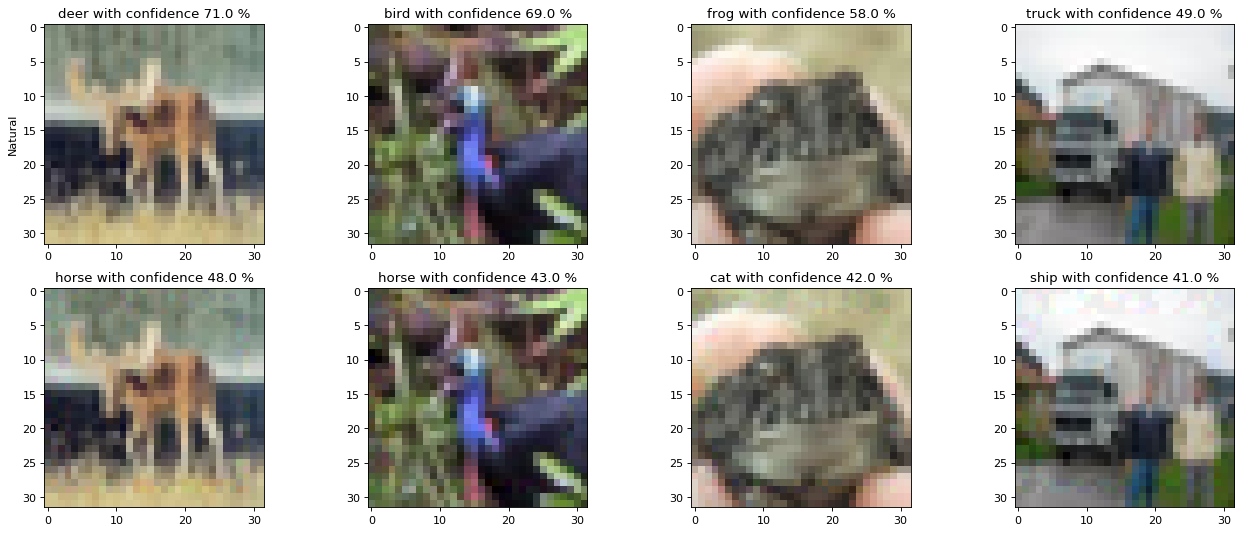

In [0]:
examples = [28,24,25,16]
plt.figure(figsize=(20,8), dpi=80)
imgsadv = get_attacks([x_train[abcd] for abcd in examples], [perturbations2_train[bcde] for bcde in examples], 0.031)

for i in range(len(examples)):
  predicti1 = model.predict(x_train[examples[i]].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+1)
  plt.imshow(x_train[examples[i]])
  plt.title("{} with confidence {} %".format(classes[predicti1.argmax()], predicti1.max()//0.01))
  if(i ==0):
    plt.ylabel('Natural')
  
  predicti2 = model.predict(imgsadv[i].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+4+1)
  plt.imshow(imgsadv[i].reshape(32,32,3))
  plt.title("{} with confidence {} %".format(classes[predicti2.argmax()], predicti2.max()//0.01))
  if(i ==4):
    plt.ylabel('Adversarial')
plt.show()


## **3.Attaque aléatoire**


Pour finir, nous nous sommes posé une question, en s'entrainant sur des photos, les réseaux de neurones ne se retrouvent t'ils pas à "overfitter la réalité", en effet une image réel suit certaines normes naturellement, certaines succesions de pixels ne sont pas supposés exister.

Pour pouvoir tester cela, on applique une perturbation sur l´image, dont le sens pour chaque pixel est aléatoire.

In [64]:
epsilons = [0, 0.001, 0.003, 0.007, 0.01, 0.02, 0.031, 0.05, 0.075, 0.1]
resAccTr = []
resConfTTTr = []
resConfTFTr = []
resConfFFTr = []
resAccTe = []
resConfTTTe = []
resConfTFTe = []
resConfFFTe = []
for i in epsilons :
  print(i)
  a, b, c, d = get_evaluation(x_usedtr1, y_usedtr1, get_attacks(x_usedtr1, perturbations3_train, i))
  e, f, g, h = get_evaluation(x_usedte1, y_usedte1, get_attacks(x_usedte1, perturbations3_test, i))
  resAccTr.append(a)
  resConfTTTr.append(b)
  resConfTFTr.append(c)
  resConfFFTr.append(d)
  resAccTe.append(e)
  resConfTTTe.append(f)
  resConfTFTe.append(g)
  resConfFFTe.append(h)

0
True
372
0.5487406322499737 0.18108267415163937 0.7756679922502528
True
336
0.5531501148532076 0.16638999456380388 0.7649651910400107
0.001
True
374
0.552622974746757 0.17888308938459627 0.7732749517190265
True
336
0.5531254904117526 0.16647059466448832 0.7648408350845178
0.003
True
375
0.5548838198184967 0.17779510539630428 0.7721719519297282
True
337
0.5541275534893106 0.16552894505426827 0.763277995834011
0.007
True
375
0.5544048690795899 0.17704779654787853 0.772614294052124
True
337
0.5533034680811174 0.1653465736345631 0.7627416325605941
0.01
True
374
0.5529502318018958 0.17828468478050097 0.7737372164579637
True
335
0.5515109234687053 0.16777473099288975 0.7645690096848047
0.02
True
367
0.5452878220861119 0.18524862104095519 0.7811148018862961
True
333
0.5549252652479503 0.17047426152593054 0.7637474956634166
0.031
True
365
0.5503058506382836 0.17566819879640308 0.7819424920702633
True
328
0.5542886113358099 0.16943126283580948 0.7669174192791305
0.05
True
352
0.55951861201508


Les résultats semblent au final peu concluant, le ré seau se montre robuste face à ce genre d'attaque complètement aléatoires.

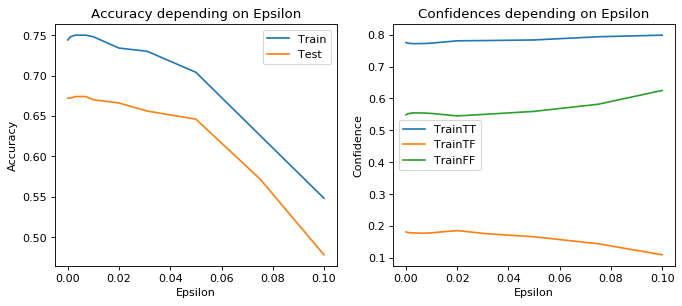

In [65]:
plt.figure(figsize=(10,4), dpi=80)
plt.subplot(121)
plt.plot(epsilons, resAccTr)
plt.plot(epsilons, resAccTe)
plt.title('Accuracy depending on Epsilon')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.show()
plt.subplot(122)
plt.plot(epsilons, resConfTTTr)
plt.plot(epsilons, resConfTFTr)
plt.plot(epsilons, resConfFFTr)
plt.title('Confidences depending on Epsilon')
plt.ylabel('Confidence')
plt.xlabel('Epsilon')
plt.legend(['TrainTT', 'TrainTF', 'TrainFF'], loc='center left')
plt.show()

(1, 32, 32, 3)


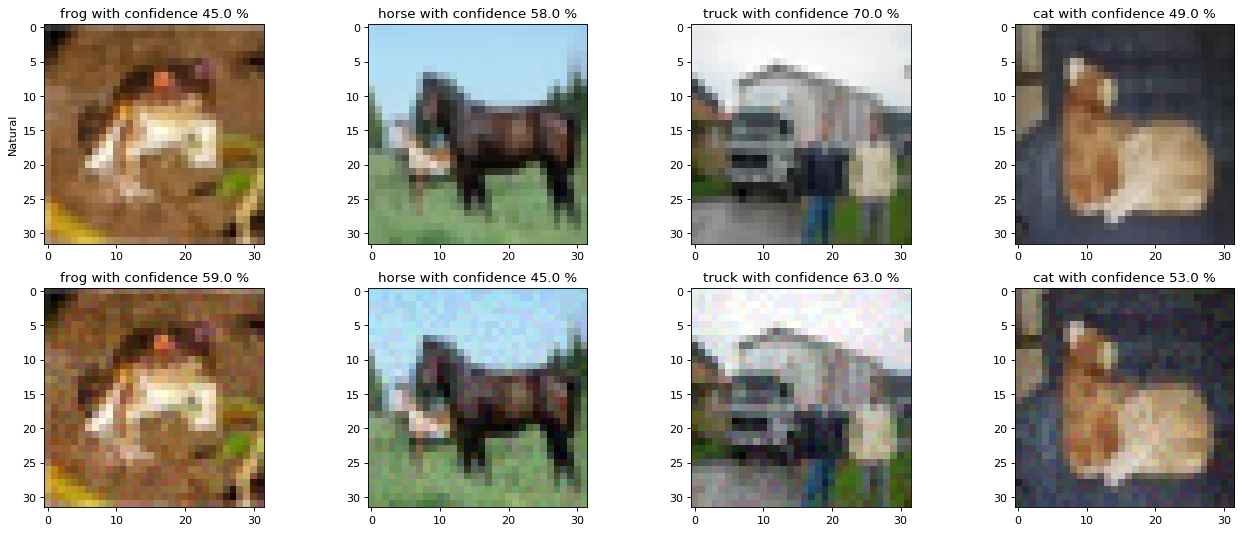

In [76]:
examples = [0,12,16,17]
plt.figure(figsize=(20,8), dpi=80)
imgsadv = get_attacks([x_train[abcd] for abcd in examples], [perturbations3_train[bcde] for bcde in examples], 0.031)
print (imgsadv[0].shape)

for i in range(len(examples)):
  predicti1 = model.predict(x_train[examples[i]].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+1)
  plt.imshow(x_train[examples[i]])
  plt.title("{} with confidence {} %".format(classes[predicti1.argmax()], predicti1.max()//0.01))
  if(i ==0):
    plt.ylabel('Natural')
  
  predicti2 = model.predict(imgsadv[i].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+4+1)
  plt.imshow(imgsadv[i].reshape(32,32,3))
  plt.title("{} with confidence {} %".format(classes[predicti2.argmax()], predicti2.max()//0.01))
  if(i ==4):
    plt.ylabel('Adversarial')
plt.show()


# II. Projected gradient descent

### Importer et Trainer le reseau

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True)

indices = np.random.randint(0, 1, 1000)   
sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self):
        self.cifar10 = datasets.CIFAR10(root='./data',
                                        download=True,
                                        train=False,
                                        transform=transforms.ToTensor())
        
    def __getitem__(self, index):
        data, target = self.cifar10[index]
        
        # Your transformations here (or set it in CIFAR10)
        
        return data, target, index

    def __len__(self):
        return len(self.cifar10)

dataset = MyDataset()
loader = DataLoader(dataset,
                    batch_size=1,
                    shuffle=True,
                    num_workers=1)

Files already downloaded and verified


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

**Trainer le classique reseau**

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.avgpool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.234
[1,  4000] loss: 2.062
[1,  6000] loss: 1.986
[1,  8000] loss: 1.844
[1, 10000] loss: 1.787
[1, 12000] loss: 1.725
[1, 14000] loss: 1.684
[1, 16000] loss: 1.638
[1, 18000] loss: 1.590
[1, 20000] loss: 1.536
[1, 22000] loss: 1.500
[1, 24000] loss: 1.486
[1, 26000] loss: 1.467
[1, 28000] loss: 1.441
[1, 30000] loss: 1.421
[1, 32000] loss: 1.365
[1, 34000] loss: 1.368
[1, 36000] loss: 1.322
[1, 38000] loss: 1.332
[1, 40000] loss: 1.335
[1, 42000] loss: 1.291
[1, 44000] loss: 1.263
[1, 46000] loss: 1.210
[1, 48000] loss: 1.261
[1, 50000] loss: 1.203
[2,  2000] loss: 1.194
[2,  4000] loss: 1.159
[2,  6000] loss: 1.159
[2,  8000] loss: 1.105
[2, 10000] loss: 1.127
[2, 12000] loss: 1.106
[2, 14000] loss: 1.106
[2, 16000] loss: 1.114
[2, 18000] loss: 1.095
[2, 20000] loss: 1.077
[2, 22000] loss: 1.108
[2, 24000] loss: 1.016
[2, 26000] loss: 1.007
[2, 28000] loss: 0.993
[2, 30000] loss: 1.000
[2, 32000] loss: 1.031
[2, 34000] loss: 1.035
[2, 36000] loss: 1.019
[2, 38000] 

In [20]:
#Whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


In [18]:
torch.save(net, 'net.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AvgPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

In [0]:
net = torch.load('net.pth')

## Descente de Gradient Projetée (PGD)

FGSM est un processus en une étape pour générer des adversaires. Il donne assez bien et rapidement des adversaires, mais ce n'est certainement pas la meilleure méthode disponible pour le faire. Une variante plus forte de cette attaque serait la Descente de Gradient Projetée (PGD).

Nous faisons une projection sur la fonction de perte négative :

$$x^{t+1} = \Pi_{x+S}(x^t+\alpha*sign(\bigtriangledown _xL(\theta,x,y)))$$

In [0]:
def pgd_attack(model, image, label, eps, step, iters=10) :
    loss_fn = nn.CrossEntropyLoss()
        
    ori_image = image.data
        
    for i in range(iters) :    
        image.requires_grad = True
        predicted = model(image)

        model.zero_grad()
        loss = loss_fn(predicted, label)
        loss.backward()

        #Gradient calculation
        adv_image = image + step*image.grad.sign()

        # Project back into l_norm ball and correct range
        eta = torch.clamp(adv_image - ori_image, min=-eps, max=eps)
        image = torch.clamp(ori_image + eta, min=0, max=1).detach_()
            
    return image

Test sur une image

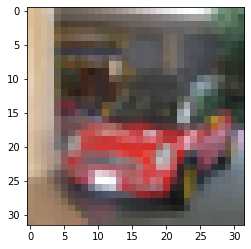

    c a r
    c a r


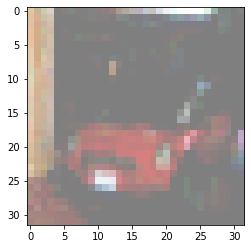

  d e e r


In [52]:
# get random training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show orginal image
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels]))
outputs = net(images)
_, predicted = torch.max(outputs.data, 1) #killer
print(' '.join('%5s' % classes[predicted]))

# Show Attack image
images_adv = pgd_attack(net, images, labels, 0.3, 0.01)
imshow(torchvision.utils.make_grid(images_adv))
outputs = net(images_adv) #Label calculation
_, predicted = torch.max(outputs.data, 1) #killer
print(' '.join('%5s' % classes[predicted]))

**Évaluer les exemples contradictoires**

Dans un premier temps, nous évaluons la précision obtenue en fonction d'Epsilon et du pas de gradient.
Nous commençons par l'espion d'abord.

In [44]:
epsl = np.array([0, 0.001, 0.01, 0.03, 0.1, 0.3, 1])
epsl
#Whole dataset
resAccTr = []
for e_i in epsl:
  correct = 0
  total = 0
  for data in testloader:
          images, labels = data
          images = pgd_attack(net, images, labels, e_i ,step = 0.01)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  taux = correct / total
  resAccTr.append(taux)
  print('Accuracy: %d %%' % (
      100 * taux))

Accuracy: 31 %
Accuracy: 30 %
Accuracy: 22 %
Accuracy: 11 %
Accuracy: 1 %
Accuracy: 1 %
Accuracy: 0 %


Text(0.5, 1.0, 'Accuracy in function of eps (test dataset)')

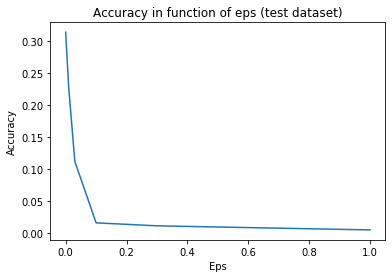

In [54]:
plt.plot(epsl, resAccTr)
plt.xlabel('Eps')
plt.ylabel('Accuracy')
plt.title('Accuracy in function of eps (test dataset)')

Nous constatons que plus l4eps est grand, plus la précision de notre modèle diminue, donc plus d'exemples adverses sont générés. Nous pouvons prendre eps = 0,3 (la precision obtenue est 1%).

Nous étudions ensuite la différence de précision en fonction du pas de gradient.

In [47]:
stepl = np.array([0, 0.001, 0.01, 0.03, 0.1, 0.3, 1])
#Whole dataset
stepAcc = []
for step_i in stepl:
  correct = 0
  total = 0
  for data in testloader:
          images, labels = data
          images = pgd_attack(net, images, labels, eps = 0.3 , step_i)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  taux = correct / total
  stepAcc.append(taux)
  print('Accuracy: %d %%' % (
      100 * taux))

Accuracy: 31 %
Accuracy: 22 %
Accuracy: 1 %
Accuracy: 0 %
Accuracy: 0 %
Accuracy: 0 %
Accuracy: 1 %


Text(0.5, 1.0, 'Accuracy in function of step gradient (test dataset)')

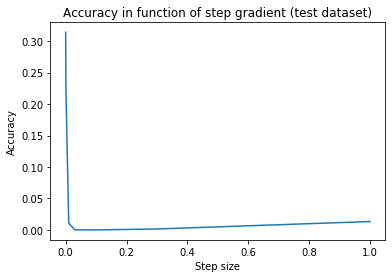

In [53]:
plt.plot(stepl, stepAcc)
plt.xlabel('Step size')
plt.ylabel('Accuracy')
plt.title('Accuracy in function of step gradient (test dataset)')

On trouve qu'il faut choisir une valeur soit pas trop petite, soit pas trop grande pour l'étape de gradient afin d'obtenir un bon résultat.

En résumé, nous avons obtenu de bons résultats avec le PGD.

# III. Black box attack

Dans cette partie, l'objectif est le même que le précédent, mais les contraintes sont plus fortes. Au lieu d'avoir un accès total au réseau, la seule opération autorisée sur ce dernier est de l'appeler sur des entrées et d'observer sa réponse. De plus, sa réponse est parfois moins détaillée que le poids pour chacune des classes.

### Imports et réseau

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

def tp(m) :
    return np.transpose(m,[1,0,2])

path = "data/"
model = keras.models.load_model(path+'modelP3.h5')
model.summary()

Model: "classif"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 32)          0   

In [2]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

10000/1 - 3s - loss: 1.1574 - accuracy: 0.6203
Test loss: 1.0721267587661742
Test accuracy: 0.6203


On travaille avec les images suivantes :

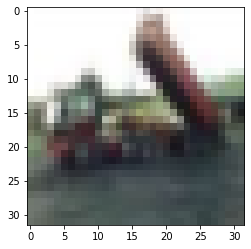

[[0.07381149 0.07172437 0.0762818  0.02487351 0.00127797 0.03920057
  0.00533078 0.02712727 0.13623233 0.54413986]]


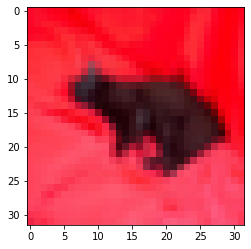

[[8.2247752e-01 1.3282711e-03 1.3770411e-03 1.5960367e-01 1.4622783e-04
  8.8090468e-03 5.2132476e-03 2.3340892e-05 6.7093864e-04 3.5069403e-04]]


In [3]:
used = 2
adv = 21

plt.imshow(x_train[used])
plt.show()

print(model.predict(x_train[used:used+1]))

plt.imshow(x_train[adv])
plt.show()

print(model.predict(x_train[adv:adv+1]))

### Informations connues

En suivant l'article proposé, nous considérons 3 cas :
- nous avons accès à la sortie du réseau en totalité ;
- nous n'avons accès qu'aux probabilités des k meilleures sorties ;
- nous n'avons accès qu'aux rangs des k meilleures sorties.

Dans toute la suite, k=5.

Note : les figures utilisées lors de la présentation avaient été réalisées avec une erreur dans le calcul du gradient. Les résultats suivants diffèrent donc.

In [4]:
def kill(killer, p) :
  if p<killer : return 0
  else : return p

# Keeps the top k probabilities, sets the rest to 0
def partialize(prob, k) :
  prob_sorted = np.sort(prob)
  max_kept = prob_sorted[-k]
  return np.array([kill(max_kept,p) for p in prob])

# Returns the ranks using labels only
def ranks(prob, k) :
  l = list(enumerate(prob))
  l.sort(key= lambda c : c[1], reverse=True)
  
  ranks = np.zeros(len(prob))
  for i in range(k) :
    ranks[l[i][0]] = k-i
  return ranks


def total_prediction(x) :
  return model.predict(np.array([x]))[0]

### Gradient et projection

Voici les fonctions utilisée pour estimer le gradient et pour projeter en suivant la norme infini :

In [5]:
def nes_grad(f, x, y, sigma, samples) :
  g = np.zeros(shape)
  for _ in range(samples) :
    u = np.random.normal(loc=.0, scale=1., size=shape)
    g += f(x+sigma*u)[y]*u
    g -= f(x-sigma*u)[y]*u
  return g/(2*samples*sigma)

In [6]:
def proj1D(z, x, eps) :
  return max([0., x-eps, min([1., x+eps, z])])
proj = np.vectorize(proj1D)

### 1) Connaissance totale de l'estimation

Lorsque l'on connait totalement l'estimation des différentes probabilités par le réseau, le problème peut être résolu en suivant l'algorithme simple suivant :

In [7]:
def general(x, y, eps, sigma=.1, samples=100, learning_rate=.2, slippery=.7, targeted=False, history=None, proj=proj) :
  predict = total_prediction
  x_adv = x
  momentum = 0

  iteration = 0
  if history != None :
    history.append(x_adv)

  while np.argmax(predict(x_adv)) != y or iteration < 40 :
    iteration += 1

    grad = nes_grad(predict,x_adv,y,sigma,samples)
    if targeted :
      grad = -grad
    momentum = slippery*momentum + grad
    x_adv = proj( x_adv-learning_rate*momentum ,x,eps)

    if iteration%5 == 0 :
      print("Iteration", iteration)
      plt.imshow((x_adv* 255).astype(np.uint8))
      plt.show()
      print(predict(x_adv))
    if history != None :
      history.append(x_adv)

  return x_adv

[0.07381149 0.07172437 0.0762818  0.02487351 0.00127797 0.03920057
 0.00533078 0.02712727 0.13623233 0.54413986]
Iteration 5


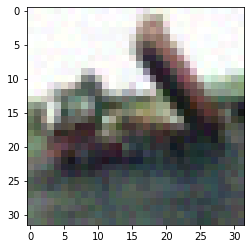

[0.28430185 0.031536   0.15570068 0.01885752 0.00254269 0.01848386
 0.003115   0.0212155  0.3288756  0.13537136]
Iteration 10


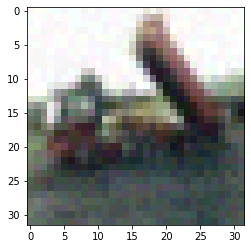

[0.36558694 0.03836257 0.13591817 0.0178637  0.00248211 0.01777784
 0.0030884  0.02002794 0.26610428 0.13278803]
Iteration 15


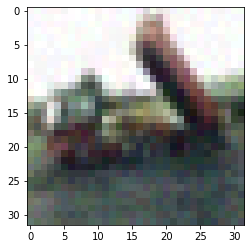

[0.36475056 0.03572569 0.11062092 0.01477473 0.0020065  0.0121048
 0.00256408 0.01742737 0.29337862 0.1466467 ]
Iteration 20


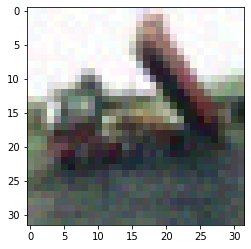

[0.42459702 0.03151548 0.12855381 0.0137546  0.0021294  0.01334674
 0.00227294 0.02297854 0.24505533 0.1157961 ]
Iteration 25


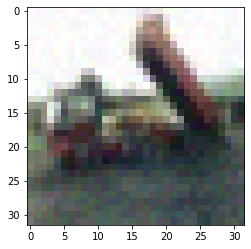

[0.3806093  0.0323927  0.10265233 0.01636647 0.00236522 0.01287689
 0.00226942 0.01904222 0.3052094  0.12621605]
Iteration 30


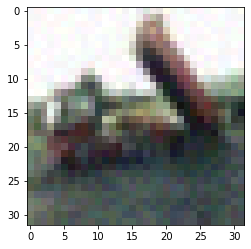

[0.35250464 0.03767594 0.12983535 0.01988163 0.0025924  0.02046479
 0.00300689 0.02324039 0.27357793 0.13721998]
Iteration 35


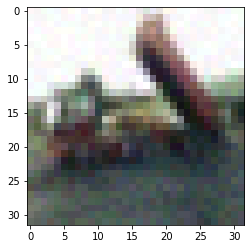

[0.3404588  0.03090236 0.14131734 0.01892686 0.00245599 0.01572424
 0.00253122 0.02220425 0.30109575 0.1243832 ]
Iteration 40


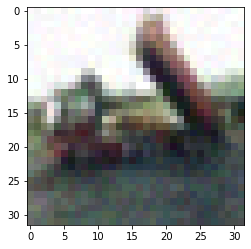

[0.36543056 0.02936253 0.13437228 0.01763801 0.0021824  0.01482102
 0.00264647 0.01868873 0.27212408 0.14273389]


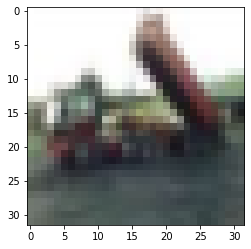

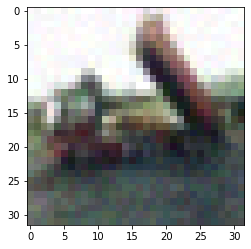

In [9]:
x = x_train[used]
y = total_prediction(x_train[adv]).argmax()
dim = 32*32*3
shape = (32,32,3)
eps = .03

history_general=[]
print(total_prediction(x))
x2 = general(x, y, eps, targeted=True, history = history_general)

plt.imshow(x)
plt.show()
plt.imshow((x2* 255).astype(np.uint8))
plt.show()

En exécutant le code précédent (interrompu après une cinquantaine d'itérations), on obtient le résultat suivant :
<img src='data/result0.jpg'>
<img src='data/curves0.jpg'>

Légende : probabilité donnée par le réseau en fonction du nombre d'itérations. En bleu clair : camion. En bleu foncé : avion.

### 2) Connaissance partielle de l'estimation

Lorsque la connaissance est partielle, l'algorithme proposé par l'article est plus compliqué :

In [11]:
def special(kind, k, x, y, x_adv, eps, eps_adv=1, eps_decay=.05, sigma=.1, samples=100,
            max_learning_rate=.2, min_learning_rate = .01, parameters=None, history=None) :
  # It is always targeted, and x_adv must have y in its top k labels
  if kind == 'partial' :
    predict = partial_prediction(k)
  elif kind == 'label-only' :
    if parameters == None :
      re_mu, re_samples = .15, 50
    else :
      re_mu, re_samples = parameters
    predict = labelusing_prediction(k,re_mu,re_samples)

  iteration = 0
  if history != None :
    history.append(x_adv)

  while eps_adv > eps or np.argmax(predict(x_adv)) != y or np.argmax(predict(x_adv)) != y :
    # The test is done twice to decrease potential variance
    iteration += 1

    eps_adv = max(eps, eps_adv-eps_decay)
    grad = nes_grad(predict,x_adv,y,sigma,samples)
    lr = max_learning_rate
    x_adv_loc = proj(x_adv + lr*grad, x, eps_adv)
    while predict(x_adv_loc)[y] == 0 :
      if lr < min_learning_rate :
        eps_adv += eps_decay
        eps_decay = eps_decay/2.
        x_adv_loc = x_adv
        break
      lr /= 2
      x_adv_loc = proj(x_adv + lr*grad, x, eps_adv)
    x_adv = x_adv_loc

    if iteration%5 == 0 :
      print("Iteration", iteration)
      plt.imshow((x_adv* 255).astype(np.uint8))
      plt.show()
      print(predict(x_adv))
      print(total_prediction(x_adv))
    if history != None :
      history.append(x_adv)

  return x_adv


def partial_prediction(k) :
  return lambda x : partialize(total_prediction(x), k)

[0.07381149 0.07172437 0.0762818  0.02487351 0.00127797 0.03920057
 0.00533078 0.02712727 0.13623233 0.54413986]
Iteration 5


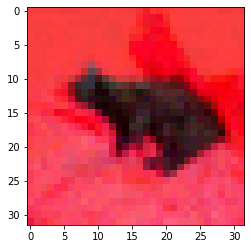

[9.74954307e-01 1.05220778e-03 0.00000000e+00 1.95335560e-02
 0.00000000e+00 1.10514730e-03 9.09641210e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[9.7495431e-01 1.0522078e-03 7.2179205e-04 1.9533556e-02 3.2356820e-05
 1.1051473e-03 9.0964121e-04 4.6964205e-06 8.9712767e-04 7.8926870e-04]
Iteration 10


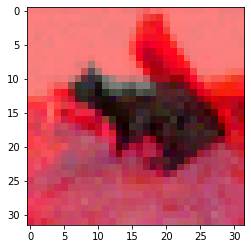

[0.92719227 0.         0.00698373 0.03701347 0.         0.
 0.         0.         0.00536725 0.01723276]
[9.2719227e-01 1.8733217e-03 6.9837258e-03 3.7013467e-02 2.5301639e-04
 2.0442903e-03 1.7679580e-03 2.7197300e-04 5.3672539e-03 1.7232759e-02]
Iteration 15


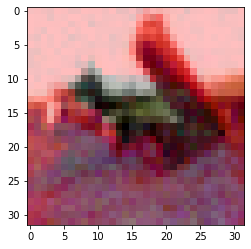

[0.76584142 0.         0.03281119 0.0766571  0.         0.02064021
 0.         0.         0.         0.07719105]
[0.7658414  0.00347339 0.03281119 0.0766571  0.00202061 0.02064021
 0.00810175 0.00381278 0.00945051 0.07719105]
Iteration 20


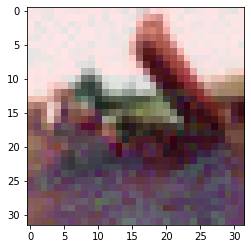

[0.09438655 0.         0.10805793 0.09252762 0.         0.
 0.         0.11322436 0.         0.43617976]
[0.09438655 0.01958072 0.10805793 0.09252762 0.00383882 0.07763907
 0.02330588 0.11322436 0.03125936 0.43617976]
Iteration 25


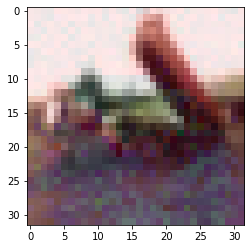

[0.08968271 0.         0.12363973 0.08966265 0.         0.
 0.         0.14242683 0.         0.39787716]
[0.08968271 0.02004238 0.12363973 0.08966265 0.00429751 0.07820743
 0.02108927 0.14242683 0.03307436 0.39787716]
Iteration 30


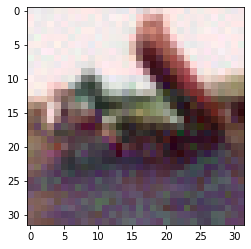

[0.14874984 0.         0.18309763 0.08852449 0.         0.
 0.         0.12151613 0.         0.29923299]
[0.14874984 0.02100557 0.18309763 0.08852449 0.00565884 0.06064502
 0.01605622 0.12151613 0.0555133  0.299233  ]
Iteration 35


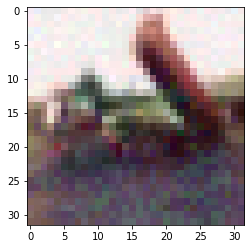

[0.24276307 0.         0.19444174 0.         0.         0.
 0.         0.09065357 0.13975112 0.19639081]
[0.24276307 0.01810116 0.19444174 0.0698906  0.00589232 0.03179061
 0.01032499 0.09065357 0.13975112 0.19639081]
Iteration 40


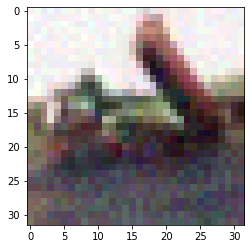

[0.43343899 0.         0.14897522 0.03149607 0.         0.
 0.         0.         0.19493245 0.11832361]
[0.433439   0.01902479 0.14897522 0.03149607 0.0041434  0.01528622
 0.00358291 0.03079641 0.19493245 0.11832361]
Iteration 45


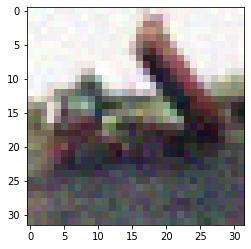

[0.58701313 0.01806137 0.07298365 0.         0.         0.
 0.         0.         0.19018389 0.09727906]
[0.5870131  0.01806137 0.07298365 0.01035838 0.00239165 0.00465641
 0.00108981 0.01598266 0.1901839  0.09727906]
Iteration 50


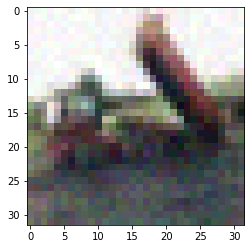

[0.57189935 0.01774421 0.0869192  0.         0.         0.
 0.         0.         0.21044245 0.07839841]
[0.57189935 0.01774421 0.0869192  0.01144055 0.00219963 0.00660876
 0.00151515 0.01283228 0.21044245 0.07839841]
Iteration 55


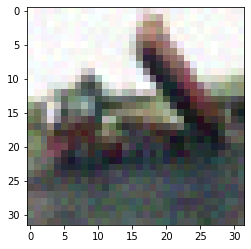

[0.52864784 0.02149084 0.08251094 0.         0.         0.
 0.         0.         0.21933693 0.1128479 ]
[0.52864784 0.02149084 0.08251094 0.01121902 0.00188794 0.00653371
 0.00142389 0.01410102 0.21933693 0.1128479 ]
Iteration 60


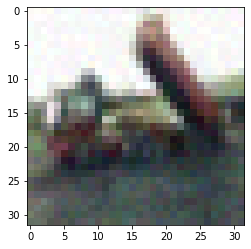

[0.41137251 0.02869574 0.09226892 0.         0.         0.
 0.         0.         0.29010892 0.13487057]
[0.4113725  0.02869574 0.09226892 0.0156402  0.00233053 0.00898878
 0.00209611 0.01362765 0.29010892 0.13487057]
Iteration 65


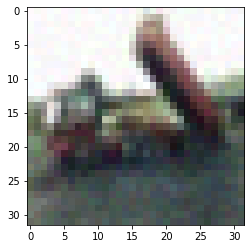

[0.34949878 0.0330753  0.1087442  0.         0.         0.
 0.         0.         0.27873158 0.17093082]
[0.34949878 0.0330753  0.1087442  0.01813587 0.00242694 0.01472716
 0.00286467 0.0208647  0.27873158 0.17093082]


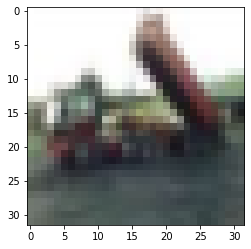

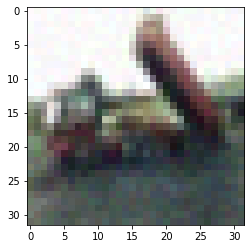

In [12]:
x = x_train[used]
y = y_train[used][0]

x_adv = x_train[adv]
y_adv = total_prediction(x_train[adv]).argmax()

dim = 32*32*3
shape = (32,32,3)
eps = .03

history_partial=[]
print(total_prediction(x))
x2 = special('partial', 5, x, y_adv, x_adv, eps, history=history_partial)

plt.imshow(x)
plt.show()
plt.imshow((x2* 255).astype(np.uint8))
plt.show()

En exécutant le code précédent (interrompu après une cinquantaine d'itérations), on obtient le résultat suivant :
<img src='data/result1.jpg'>
<img src='data/curves1.jpg'>

Légende : probabilité donnée par le réseau en fonction du nombre d'itérations. En bleu clair : camion. En bleu foncé : avion.

## 3) Connaissance des rangs uniquement

Dans le cas où seuls les rangs sont connus, on peut estimer une prédiction avec l'algorithme suivant :

In [14]:
def labelusing_prediction(k,re_mu,re_samples) :
  def predict(x) :
    p = 0
    for _ in range(re_samples) :
      delta = np.random.normal(loc=.0, scale=re_mu, size=shape)
      p += ranks(total_prediction(x+delta),k)
      p += ranks(total_prediction(x-delta),k)
    return p/(2*re_samples)
  return predict

On appelle alors le même algorithme général que dans le cas précédent :

In [ ]:
x = x_train[used]
y = y_train[used][0]

x_adv = x_train[adv]
y_adv = total_prediction(x_train[adv]).argmax()

dim = 32*32*3
shape = (32,32,3)
eps = .03

history_lo=[]
print(total_prediction(x))
x2 = special('label-only', 5, x, y_adv, x_adv, eps, history=history_lo)

plt.imshow(x)
plt.show()
plt.imshow((x2* 255).astype(np.uint8))
plt.show()

[0.07381149 0.07172437 0.0762818  0.02487351 0.00127797 0.03920057
 0.00533078 0.02712727 0.13623233 0.54413986]


En exécutant le code précédent (interrompu après une cinquantaine d'itérations), on obtient le résultat suivant :
<img src='data/result2.jpg'>
<img src='data/curves2.jpg'>

Légende : probabilité donnée par le réseau en fonction du nombre d'itérations. En bleu clair : camion. En bleu foncé : avion.

Cette méthode est extrêmement gourmande en calcul étant donné que l'estimation de la valeur en un point nécessite une cinquantaine d'appels au réseau.
Nous n'avons pas réussit à obtenir de résultats significatifs en l'utilisant.

### 4) Modification de la projection

Dans ce qui précède, la projection était réalisée selon la norme infinie.
Il en résulte des images qui, si elles sont proches des images originelles, sont peu naturelles : on voit localement que les couleurs sont discontinues.
Nous avons donc tenté de remédier à ce problème en utilisant une projection visant à non seulement obtenir un résultat proche de l'image originelle, mais surtout des gradient proches des gradients originels.
A des fins de comparaisons, nous effectueront les tests avec l'algorithme black-box où les prédictions sont entièrement connues, et nous comparerons également avec la projection suivant la norme euclidienne.

In [16]:
def trunc1D(z) :
  return max([0., min([1., z])])
trunc = np.vectorize(trunc1D)
def projL2(z,x,eps) :
  z = trunc(z)
  diff = np.linalg.norm(z-x)
  if diff <= eps :
    return z
  return x + eps*(z-x)/diff


# All the operations act on columns
def gradient(x) :
  x_top = x[:-1]
  x_bot = x[1:]
  grad = x_bot-x_top
  return grad

spill = 3
def gradient_project(gz,gx,eps) :
  # In place
  for i in range(gz.shape[1]) :
    for c in range(gz.shape[2]) :
      for j in range(gz.shape[0]) :
        if gz[j,i,c] > gx[j,i,c]+eps :
          diff = gz[j,i,c] - (gx[j,i,c]+eps)
          gz[j,i,c] -= diff
          for k in range(j+1, min(j+spill+1, gz.shape[0])) :
            gz[k,i,c] += diff/spill
        if gz[j,i,c] < gx[j,i,c]-eps :
          diff = gz[j,i,c] - (gx[j,i,c]-eps)
          gz[j,i,c] -= diff
          for k in range(j+1, min(j+spill+1, gz.shape[0])) :
            gz[k,i,c] += diff/spill

def integrate(grad, init) :
  x = np.empty((grad.shape[0]+1,init.shape[0],init.shape[1]))
  x[0] = init
  for i,g in enumerate(grad) :
    x[i+1] = x[i] + g
  return x

def proj_perso(z,x,eps) :
  # You have to initialize v_grad_x=gradient(x) and h_grad_x=gradient(tp(x))
  for i in range(3) :
    z = proj(z,x,5*eps)
    gz = gradient(z)
    init = x[0]
    gradient_project(gz, v_grad_x, eps)
    z = integrate(gz, init)
    z = proj(z,x,5*eps)
    gz = gradient(tp(z))
    init = x[:,0]
    gradient_project(gz, h_grad_x, eps)
    z = tp(integrate(gz, init))
  return proj(z,x,5*eps)

Informellement, on projete alternativement sous forme de gradient vertical, de gradient horizontal et d'image brute, suivant la norme infinie. On l'itère 3 fois, afin de faire converger, car sinon une projection faite au début risquerait de voir la norme correspondante augmentée par les suivantes.
Cet algorithme ne donne bien sûr aucune garantie théorique, mais le seule objectif est d'obtenir une image qui "rend bien" à l'oeil nu.

[0.07381149 0.07172437 0.0762818  0.02487351 0.00127797 0.03920057
 0.00533078 0.02712727 0.13623233 0.54413986]
Iteration 5


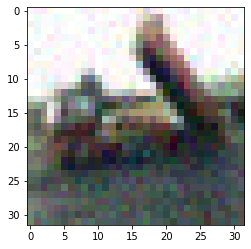

[0.5281217  0.01255531 0.08705999 0.00647013 0.00208242 0.00309568
 0.00083843 0.0062995  0.31909913 0.03437763]
Iteration 10


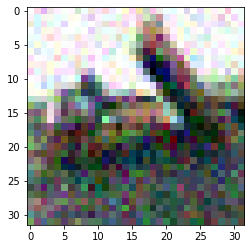

[9.75683630e-01 1.64437585e-03 9.49866045e-03 2.68386531e-04
 4.31909255e-04 1.03688275e-04 4.95715321e-05 9.59623489e-04
 8.36009718e-03 3.00012948e-03]
Iteration 15


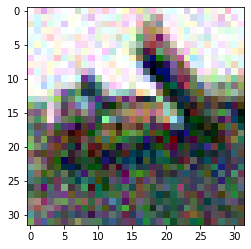

[9.8955685e-01 8.0985355e-04 3.8704418e-03 9.4764080e-05 1.8004581e-04
 2.4830604e-05 1.8345294e-05 3.2959503e-04 3.7078364e-03 1.4074380e-03]
Iteration 20


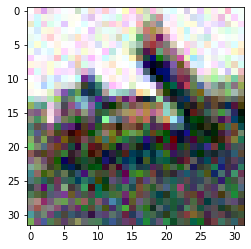

[9.92375314e-01 5.04450814e-04 2.64481129e-03 5.93127261e-05
 1.16507385e-04 1.17481586e-05 1.07633141e-05 1.80243442e-04
 3.12987878e-03 9.66977910e-04]
Iteration 25


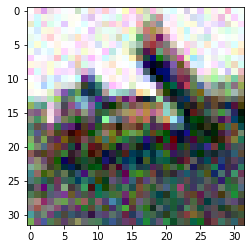

[9.9393153e-01 3.8577445e-04 2.0075152e-03 4.2790874e-05 8.9154506e-05
 7.3140400e-06 7.5278117e-06 1.2761101e-04 2.6591667e-03 7.4163434e-04]
Iteration 30


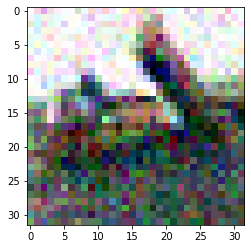

[9.9487621e-01 3.0846923e-04 1.6603937e-03 3.3058946e-05 7.2571333e-05
 5.2899004e-06 5.8739433e-06 9.9062796e-05 2.3395852e-03 5.9934770e-04]
Iteration 35


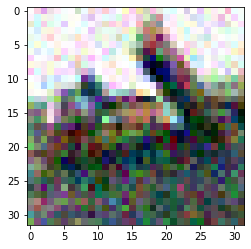

[9.9560648e-01 2.5256735e-04 1.4250404e-03 2.6495056e-05 6.2005296e-05
 4.0628929e-06 4.7755616e-06 8.1048667e-05 2.0513870e-03 4.8621156e-04]
Iteration 40


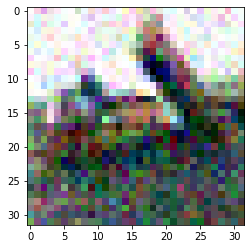

[9.9618334e-01 2.1486511e-04 1.2364308e-03 2.1769070e-05 5.3333642e-05
 3.2300936e-06 3.9550882e-06 6.7392401e-05 1.8038109e-03 4.1186879e-04]


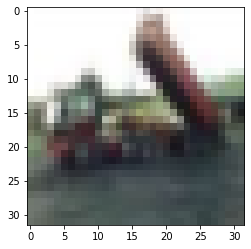

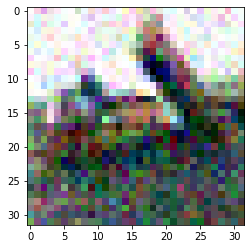

[0.07381149 0.07172437 0.0762818  0.02487351 0.00127797 0.03920057
 0.00533078 0.02712727 0.13623233 0.54413986]
Iteration 5


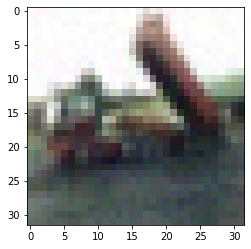

[0.20792902 0.05440645 0.12720403 0.0260099  0.00225862 0.03121453
 0.00423098 0.03071125 0.2770324  0.23900275]
Iteration 10


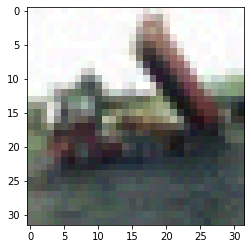

[0.22977544 0.0510742  0.10935399 0.02235213 0.00206595 0.02290303
 0.00370535 0.02610177 0.3036939  0.2289743 ]
Iteration 15


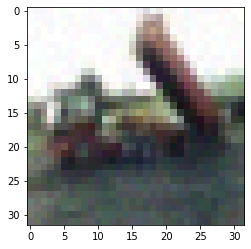

[0.25076643 0.04277587 0.10838383 0.02524189 0.0024658  0.0247394
 0.00351494 0.03061694 0.2956857  0.21580923]
Iteration 20


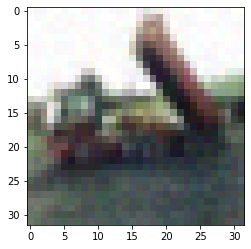

[0.25872552 0.04546491 0.11714649 0.02375236 0.00234646 0.02503939
 0.00350803 0.02361014 0.29964593 0.20076081]
Iteration 25


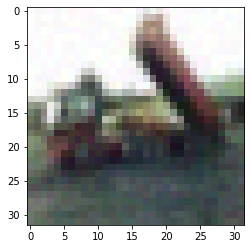

[0.26352924 0.04329189 0.11474705 0.02581124 0.0025281  0.02769888
 0.00366199 0.02918559 0.2623927  0.22715332]
Iteration 30


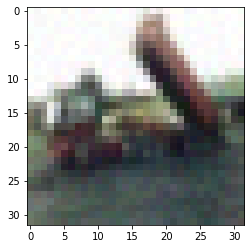

[0.26098678 0.04947932 0.13321166 0.02568984 0.00246055 0.0299143
 0.0042161  0.032316   0.24615237 0.21557312]
Iteration 35


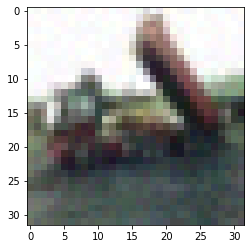

[0.2389891  0.05039594 0.13775955 0.02626745 0.00230579 0.02633839
 0.00421435 0.02901562 0.2513942  0.23331957]
Iteration 40


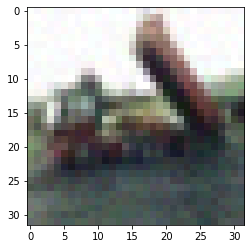

[0.2454872  0.05206426 0.11277153 0.02309221 0.00233698 0.02275392
 0.00348644 0.02264486 0.30244324 0.21291935]
Iteration 45


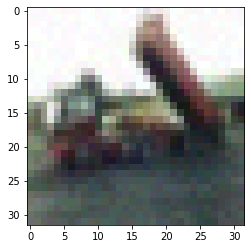

[0.2607606  0.0499219  0.11551201 0.0226757  0.0021612  0.02438656
 0.00345447 0.02495348 0.2652887  0.23088539]
Iteration 50


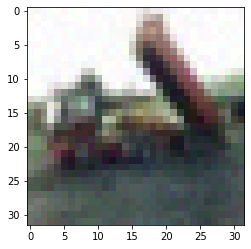

[0.26671305 0.04810971 0.11516114 0.02016311 0.00198672 0.01967853
 0.00412406 0.02085812 0.277034   0.22617154]
Iteration 55


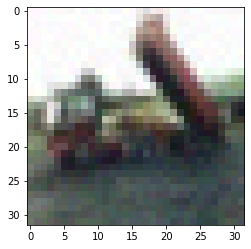

[0.25239608 0.04170333 0.12129771 0.02098844 0.0021615  0.01948643
 0.00342278 0.02173648 0.2851796  0.23162764]
Iteration 60


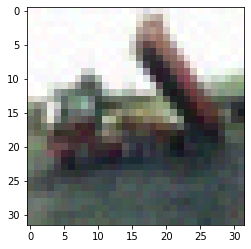

[0.23736534 0.04296963 0.10021922 0.02315723 0.00218767 0.02229172
 0.0039243  0.02293658 0.2893859  0.2555624 ]


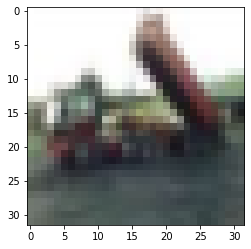

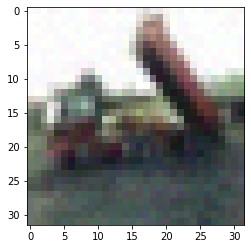

In [17]:
x = x_train[used]
y = total_prediction(x_train[adv]).argmax()
dim = 32*32*3
shape = (32,32,3)


eps = .8

history_l2=[]
print(total_prediction(x))
x2 = general(x, y, eps, targeted=True, history = history_l2)

plt.imshow(x)
plt.show()
plt.imshow((x2* 255).astype(np.uint8))
plt.show()


eps = .02

history_perso=[]
print(total_prediction(x))
x2 = general(x, y, eps, targeted=True, history = history_perso)

plt.imshow(x)
plt.show()
plt.imshow((x2* 255).astype(np.uint8))
plt.show()

En exécutant le code précédent (interrompu après une cinquantaine d'itérations), on obtient le résultat suivant :
<img src='data/result4.jpg'>
<img src='data/curves4.jpg'>

Légende : probabilité donnée par le réseau en fonction du nombre d'itérations. En bleu clair : camion. En bleu foncé : avion.

On obtient effectivement une image qui à l'oeil nu semble naturelle, quoique malheureusement une teinte verte sur la droite de la route paraisse suspecte.